<a href="https://colab.research.google.com/github/Jiyong-Jeon/GAN_study/blob/main/GAN_In_Action/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

In [3]:
# 주요 변수 정의
batch_size = 100
original_dim = 784    # MNIST 이미지의 높이 x 너비
latent_dim = 2
intermediate_dim = 256
epochs = 50           # 애폭 수
epsilon_std = 1.0

## 샘플링 헬퍼 함수 정의하기

[PEP484](https://www.python.org/dev/peps/pep-0484/)를 따라 타입 힌트를 사용하여 함수를 정의합니다.

이 함수를 [람다 함수](https://www.youtube.com/watch?time_continue=48&v=CPFKJRNAje8) 또는 익명의 함수로 사용하기 때문에 매개변수는 튜플이어야 합니다.

람다는 또 다른 함수이기 때문에 아래 코드에서 두 개의 함수를 정의합니다.

이 책의 포럼에서 Branko Blagojevic가 [제안한 내용](https://forums.manning.com/posts/list/45083.page)을 참고하여 구현했습니다.

In [4]:
def sampling(args: tuple):
    # 튜플로 매개변수를 감쌉니다.
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon # 2차원 가우스 분포

## 인코더 만들기

In [5]:
x = Input(shape=(original_dim,), name="input")  # 인코더 입력

h = Dense(intermediate_dim, activation='relu', name="encoding")(x) # 중간 층

z_mean = Dense(latent_dim, name="mean")(h)     # 잠재 공간의 평균을 정의합니다.

z_log_var = Dense(latent_dim, name="log-variance")(h)    # 잠재 공간의 로그 분산을 정의합니다.

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])    # 텐서플로 백엔드를 사용할 때는 output_shape이 꼭 필요한 것은 아닙니다.

encoder = Model(x, [z_mean, z_log_var, z], name="encoder")  # 케라스 모델로 인코더를 정의합니다.

encoder.summary()  # 인코더 구조를 출력합니다.

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

## 디코더 만들기

In [7]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input") # 디코더 입력

decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)  # 잠재 공간을 중간 층의 차원으로 변환하기

x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)  # 원본 크기로 변환

decoder = Model(input_decoder, x_decoded, name="decoder")  # 케라스 모델로 디코더를 정의합니다.
decoder.summary() # 디코더 구조 출력

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


## 모델 결합 (VAE 정의)

In [21]:
# 인코더의 출력을 디코더에 사용합니다.
output_combined = decoder(encoder(x)[2])
# 입력과 출력을 연결합니다.
vae = Model(x, output_combined)
# 모델 구조를 출력합니다.
vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


## 손실함수 정의
이 책에서 [KL 손실](https://ko.wikipedia.org/wiki/%EC%BF%A8%EB%B0%B1-%EB%9D%BC%EC%9D%B4%EB%B8%94%EB%9F%AC_%EB%B0%9C%EC%82%B0)과 [크로스-엔트로피 손실](https://ko.wikipedia.org/wiki/%EA%B5%90%EC%B0%A8_%EC%97%94%ED%8A%B8%EB%A1%9C%ED%94%BC) 사용

In [22]:
kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean),
    axis=-1)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss="binary_crossentropy")
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          201988      ['input[0][0]']                  
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          202256      ['encoder[11][2]']               
                                                                                            

## MNIST 훈련 데이터
데이터 로드 및 전처리

In [23]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11490434/11490434 [==============================] - 0s 0us/step


## 학습

In [24]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 13s 18ms/step - loss: 0.2878
Epoch 2/50
600/600 [==============================] - 10s 17ms/step - loss: 0.2440
Epoch 3/50
600/600 [==============================] - 10s 17ms/step - loss: 0.2375
Epoch 4/50
600/600 [==============================] - 12s 19ms/step - loss: 0.2322
Epoch 5/50
600/600 [==============================] - 12s 21ms/step - loss: 0.2288
Epoch 6/50
600/600 [==============================] - 12s 20ms/step - loss: 0.2259
Epoch 7/50
600/600 [==============================] - 11s 19ms/step - loss: 0.2232
Epoch 8/50
600/600 [==============================] - 9s 16ms/step - loss: 0.2211
Epoch 9/50
600/600 [==============================] - 18s 30ms/step - loss: 0.2194
Epoch 10/50
600/600 [==============================] - 18s 30ms/step - loss: 0.2179
Epoch 11/50
600/600 [==============================] - 10s 17ms/step - loss: 0.2164
Epoch 12/50
600/600 [==============================] - 13s 21ms/step - loss: 0.2151
Ep

## 결과
- 모델을 사용해 데이터 생성

1/1 [==============================] - 0s 32ms/step


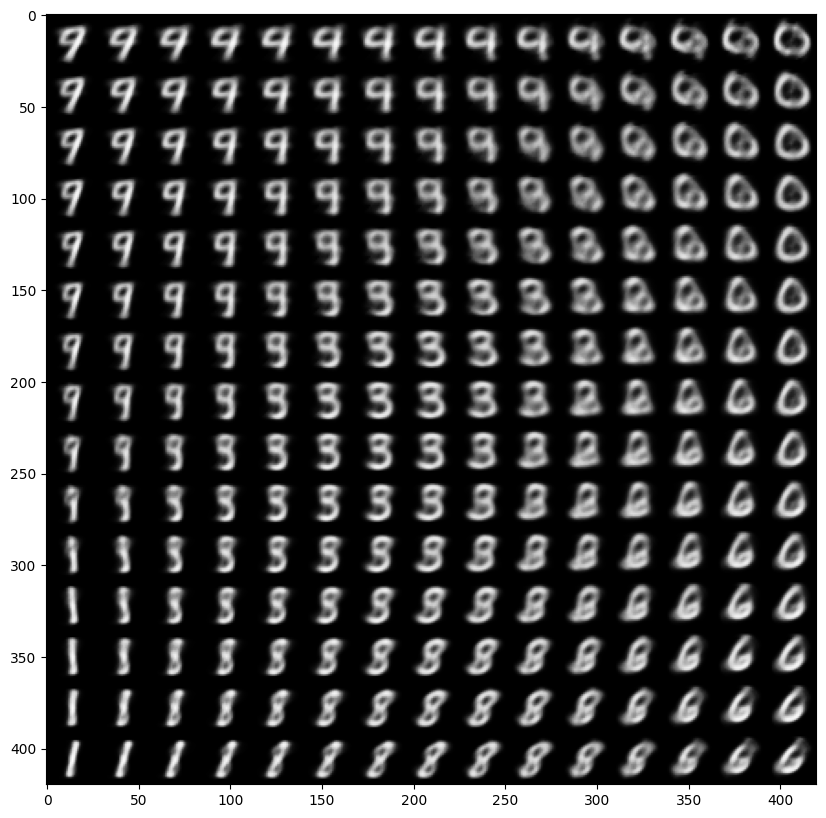

In [25]:
# 숫자의 2D 매니폴드 출력하기
n = 15  # 15x15 숫자를 담은 그림
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 잠재 공간을 가우스 분포로 가정했기 때문에 잠재 변수 z의 값을 만들기 위해
# 일정 간격으로 떨어진 좌표를 가우스 분포의 역 CDF(ppf)를 통해 변환합니다.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

- 잠재 공간 시각화

100/100 [==============================] - 1s 5ms/step


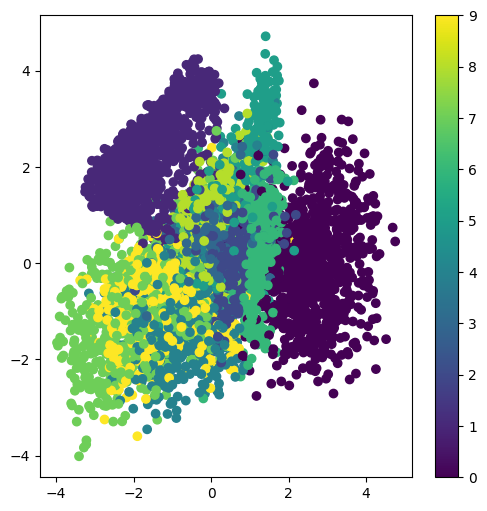

In [26]:
# 잠재 공간에 투영된 숫자 클래스의 2D 그래프
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()